In [4]:
import pennylane as qml
import pennylane.numpy as np
from model import Model

In [5]:
name = 'phong_20'
def func(n, phi):
    return np.cos(phi) ** n
consts = {'ks': 0.5}
scalars = {'n': {'range':(20,20), 'type': np.uint32}}
angles = {'phi': {'range':(0, np.pi / 2)}}

In [6]:
model = Model(name)
model.set_function(func)
# model.set_consts(consts)
model.set_scalars(scalars)
model.set_angles(angles)

model.set_sample_size(200)

try:
	model.read_samples('samples/' + model.name + '.bin')
except FileNotFoundError:
	model.generate_samples()
	model.read_samples('samples/' + model.name + '.bin')

model.separate()

(<Figure size 4300x300 with 1 Axes>, <Axes: >)

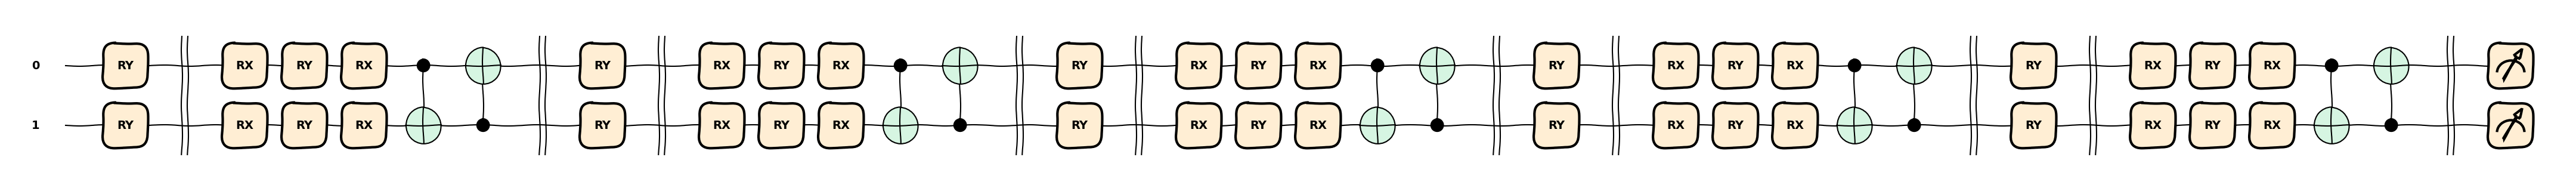

In [7]:
n_qubits = 2
layers = 5

model.push_extra('n_qubits', n_qubits)
model.push_extra('layers', layers)
model.generate_device(n_qubits)

def embedding(data, n_qubits, params):
	for i in range(n_qubits):
		if i < len(model.scalars):
			value = data[i]
			name = model.header[i + len(model.consts)]
			(min, max) = model.scalars.get(name).get('range')
			if min == max:
				value = value / max * np.pi / 2
			else:
				value = (value - min) / (max - min) * np.pi
			qml.RY(params[i] * value, wires=i)
		else:
			qml.RY(params[i] * data[i], wires=i)

	qml.Barrier()

def rot_ent(params, n_qubits):
	if len(params) < n_qubits * 3:
		raise ValueError('Not enough params')

	for i in range(n_qubits):
		qml.RX(params[3 * i], wires=i)
		qml.RY(params[3 * i + 1], wires=i)
		qml.RX(params[3 * i + 2], wires=i)

	for i in range(n_qubits):
		qml.CNOT(wires=[i, (i + 1) % n_qubits])

	qml.Barrier()

def _circuit(data, params):
	layers = model.extra.get('layers')
	n_qubits = model.extra.get('n_qubits')
	for i in range(layers):
		temp_params = params[i * n_qubits * 4 : (i+1) * n_qubits * 4]
		embedding(data, n_qubits,temp_params[:n_qubits])

		rot_ent(temp_params[n_qubits : ], n_qubits)

	return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

def _model(circ, input, params):
	return (circ(input, params) + 1) / 2

model.set_model(_model)
model.set_circuit(_circuit)
model.generate_params((n_qubits * 4 * layers,))

qml.draw_mpl(model.circuit, style='sketch')(model.train_in, model.params)

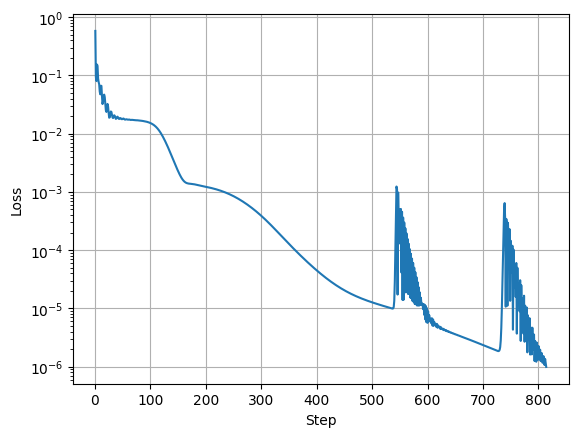

Loss: 9.92582191855028e-07


In [13]:
model.set_max_steps(500)
model.set_objective(1E-6)
model.optimization(objective=True, callback= 'graph')

In [14]:
print('Test score:', model.test())

Test score: 1.5820735107850802e-06


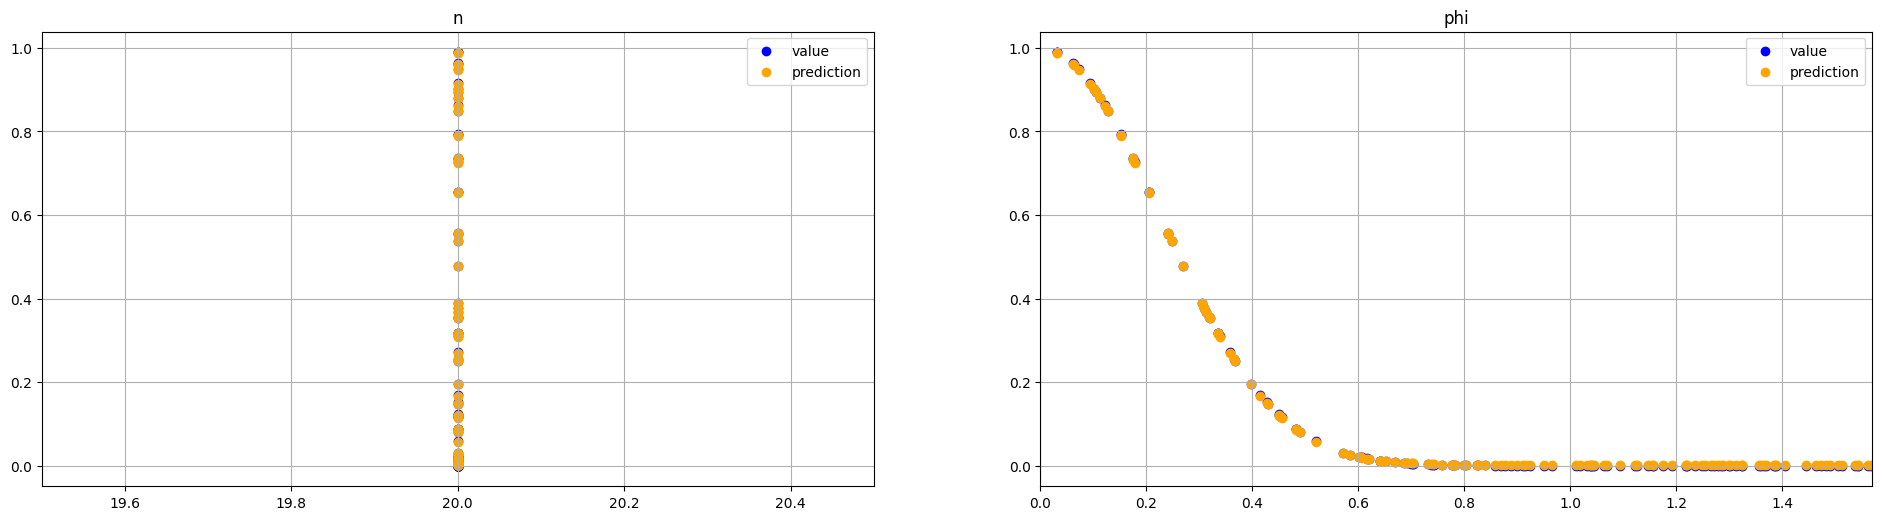

In [15]:
model.draw_train()

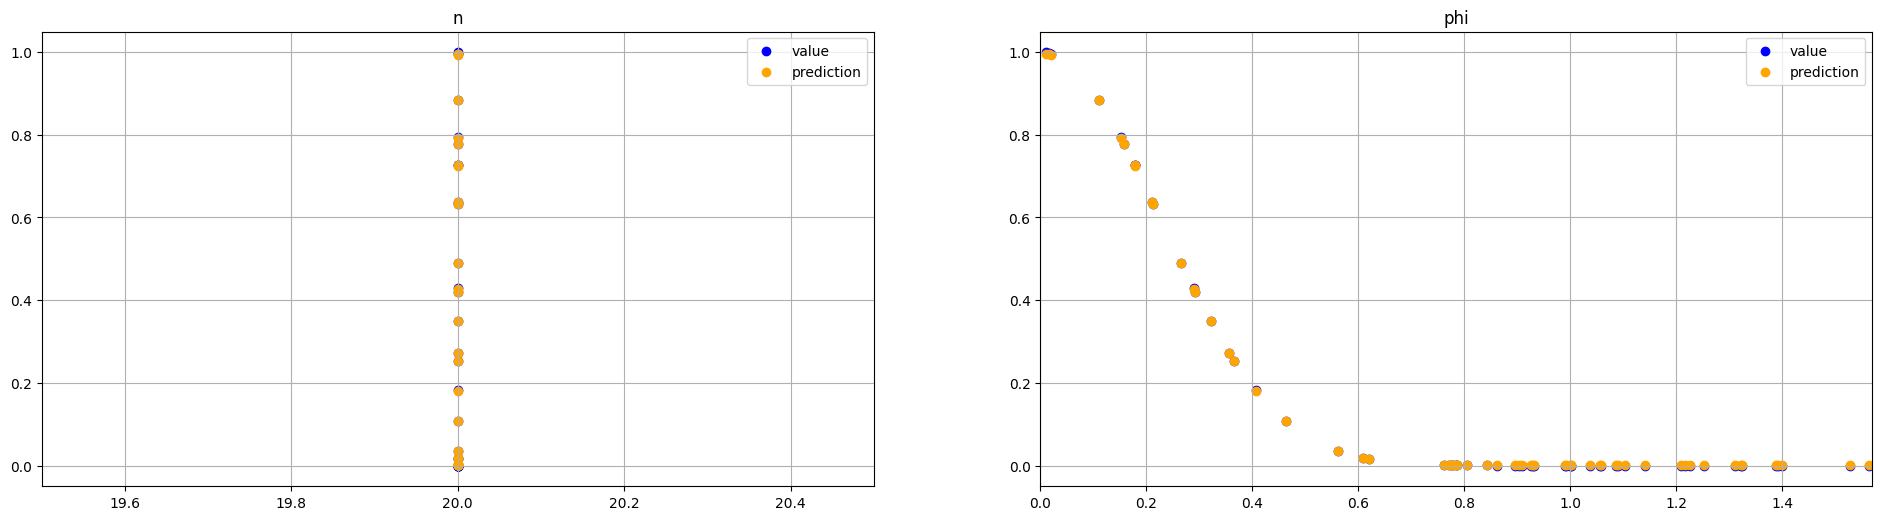

In [16]:
model.draw()

In [17]:
model.serialize('models/' + model.name + '.json')